# Smash ELO: Settling the Debate on who is the BEST at Super Smash Bros. Melee

Super Smash Bros. Melee is a fun party game published by Nintendo for the GameCube in 2001. But for my friend group, it is far from just a simple party game. It gets competitive and every game you play includes a wager of your own pride. There has always been a discussion on who we think is the best out of entire friend group, and I decided to use my programming skills to objectively determine this answer. 

I was inspired by the ranking system of chess, which uses Elo, to determine the relative skill of players and decided to apply it to the rankings of our friend group so that the number of games played isn't a huge factor in determining skill. The Elo system accounts for this variability well and is pretty simple to understand without needing too much background knowledge on the specifics. 

## Data Collection and Import

I used Google Sheets to record the data of the matches played amongst our friend group. Google Sheets is very accessible due to its collaborative nature and allowed all of us to update the list anywhere and anytime.

In [1]:
#Importing the modules needed for this project
import gspread
from df2gspread import df2gspread as d2g
from oauth2client.service_account import ServiceAccountCredentials
import pandas as pd
import numpy as np
import math

In [2]:
#The scope always looks like this so we did not need to change anything
scope = [
   'https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

#Name of our Service Account Key to establish credentials
google_key_file = 'service_key.json'
credentials = ServiceAccountCredentials.from_json_keyfile_name(google_key_file, scope)
gc = gspread.authorize(credentials)

In [3]:
#This is the Worksheet ID
spreadsheet_key = ''
#This is the sheet name
wks_name = 'Games'

#We upload the tips data to our Google Sheet. Setting the row_names to False if you did not want the index to be included
#d2g.upload(tips, spreadsheet_key, wks_name, credentials=credentials, row_names=False)

#Opening the worksheet by using Worksheet ID
workbook = gc.open_by_key(spreadsheet_key)

#Selecting which sheet to pulling the data
sheet = workbook.worksheet('Games')

#Pulling the data and transform it into a dataframe
values = sheet.get_all_values()
games = pd.DataFrame(values[1:], columns = values[0])
games['Score'] = games['Score'].astype(int)

# Check the types of all variables
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Player1      79 non-null     object
 1   Player2      79 non-null     object
 2   Winner       79 non-null     object
 3   Score        79 non-null     int32 
 4   Date         79 non-null     object
 5   P1Character  79 non-null     object
 6   P2Character  79 non-null     object
dtypes: int32(1), object(6)
memory usage: 4.1+ KB


## Elo Rating System Implementation

Let me preface this section by saying I definitely did not come up with the math for this myself. As the name suggests, Arpad Elo did all the hard work already. You can learn more about it [here](https://en.wikipedia.org/wiki/Elo_rating_system#Performance_rating)!

In [4]:
# Function to calculate the Probability of player 2 beating player 1
def Probability(rating1, rating2):
 
    return 1.0 * 1.0 / (1 + 1.0 * math.pow(10, 1.0 * (rating1 - rating2) / 400))

In [5]:
def EloRating(Ra, Rb, K, d):
 
    # To calculate the Winning
    # Probability of Player B
    Pb = Probability(Ra, Rb)
 
    # To calculate the Winning
    # Probability of Player A
    Pa = Probability(Rb, Ra)
 
    # Case -1 When Player A wins
    # Updating the Elo Ratings
    if (d == "TRUE") :
        Ra = Ra + K * (1 - Pa)
        Rb = Rb + K * (0 - Pb)
     
    # Case -2 When Player B wins
    # Updating the Elo Ratings
    else :
        Ra = Ra + K * (0 - Pa)
        Rb = Rb + K * (1 - Pb)
     
    return([Ra,Rb])

Here's my little "improvement" on the traditional Elo system. I decided to factor in the score in which an opponent beats another as a sort of multiplier on how much Elo they should gain. If you win with 3 stocks, or points, over your opponent, you should deserve more Elo compared to a close game down to the last stock on both opponents.

In [6]:
def KMultiplier(winner, loser, pts):
    k = np.log(abs(pts)+1) * (2.2/((winner-loser)*.001+2.2))
    
    return k

## Calculating Players' Elo

Now that we collected the data from the Google Sheets with the match history and implemented the math behind the Elo system, it is time to apply it all together and calculate their rankings.

In [7]:
# Initialize all Elo scores at 1000
elo = { 'Jeremy': 1000, 'Ronald' : 1000, 'Jeremie' : 1000, 'Karlo' : 1000 }
elo_history = pd.DataFrame()

for i in range(0, len(games)):
    p1 = games.iloc[i]['Player1']
    p2 = games.iloc[i]['Player2']
    winner = games.iloc[i]['Winner']
    score = games.iloc[i]['Score']
    elo1 = elo[p1]
    elo2 = elo[p2]
    
    if p1 == winner:
        k = KMultiplier(elo1, elo2, score)
        # print(k)
        newElo = EloRating(elo1, elo2, k*20, 'TRUE')
    
    else:
        k = KMultiplier(elo2, elo1, score)
        # print(k)
        newElo = EloRating(elo1, elo2, k*20, 'FALSE')
        
    elo[p1] = newElo[0]
    elo[p2] = newElo[1]
    
    new_row = pd.DataFrame([elo], columns=elo.keys())
    elo_history = elo_history.append(new_row, ignore_index=True)

In [8]:
# Print out the final values of their Elo after 79 games of Smash
elo

{'Jeremy': 944.6289753986599,
 'Ronald': 1015.796146346722,
 'Jeremie': 971.0443883596558,
 'Karlo': 1068.5304898949619}

In [9]:
# This dataframe shows how their Elo changed between each match
elo_history

,Jeremy,Ronald,Jeremie,Karlo
0,989.013877,1010.986123,1000.000000,1000.000000
1,982.584390,1017.415610,1000.000000,1000.000000
2,982.584390,1017.415610,993.068528,1006.931472
3,972.850093,1027.149907,993.068528,1006.931472
4,972.850093,1027.149907,979.841779,1020.158221
...,...,...,...,...
74,944.628975,1032.886532,971.044388,1051.440104
75,944.628975,1022.573502,971.044388,1061.753135
76,944.628975,1035.014850,971.044388,1049.311786
77,944.628975,1021.807871,971.044388,1062.518766


## Visualize the Data

The hard part is done. Now we need to make it look pretty for everyone to understand it easier.

In [10]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'Games Played')

<Figure size 432x288 with 0 Axes>

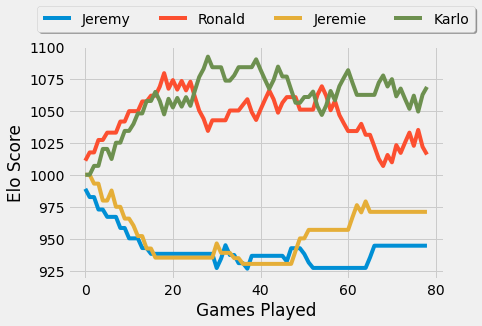

In [11]:
plt.style.use('fivethirtyeight')
plt.figure()
elo_history.plot()
plt.legend(loc='best')
#plt.xticks(rotation=90)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),ncol=4, fancybox=True, shadow=True); 
plt.ylabel('Elo Score')
plt.xlabel('Games Played')

Karlo is consistently the best when it comes to Super Smash Bros. Melee. Debate settled. Bragging rights secured. But this will only inspire all of us to get better. It feels like we have a working ranked component whenever we face each other now. There are definitely improvements I want to make in this project, such as adding Discord support so that we don't have go into the Google Sheet to update it manually, and instead use simple server commands. Overall, it was a fun little project to make and I can't wait to see where I can apply this to next. 